# Project: DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS

# Step 1: Import Essential Libraries 

In [2]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import os, json, math, joblib, requests
from pathlib import Path
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
from sqlalchemy import create_engine
import geopandas as gpd
import pyarrow, fastparquet

# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
----------------- TBC --------------------------


## 2.2 Inicitial Loading and Inspection

In [3]:
# 1. Johnny's Safety Reset
db_name = "../data/raw/supply_chain_logistics.db"
if os.path.exists(db_name):
    os.remove(db_name)
    print(f"Cleanup: Old {db_name} removed.")

# 2. Francisco's Clean Loading (DataCo specific)
# Note: Using latin1 encoding as required for this specific raw file
df = pd.read_csv('../data/raw/DataCoSupplyChainDataset.csv', encoding= 'latin1')

# Clean column names (removing spaces and special characters for SQL compatibility)
df.columns = [c.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '') for c in df.columns]


Cleanup: Old ../data/raw/supply_chain_logistics.db removed.


# Step 3: Store the Information

In [4]:
# 3. Create fresh Engine and Table
engine = create_engine(f'sqlite:///{db_name}')
# 4. Define dataset variable through SQL
df.to_sql('supply_chain', engine, if_exists= 'replace', index= False, chunksize= 10000)
print(f"Success! DataCo dataset loaded into a fresh SQL table. Shape: {df.shape}")

Success! DataCo dataset loaded into a fresh SQL table. Shape: (180519, 53)


# Step 4. Perform Descriptive Analysis
## 4.1 Data Dimensions & Types

In [5]:
# Basic shape and info
print(f"Dataset Shape: {df.shape}")
print("\nColumn Types:")
print(df.dtypes.value_counts())

Dataset Shape: (180519, 53)

Column Types:
str        24
float64    15
int64      14
Name: count, dtype: int64


## 4.2 Verifying the Data

In [6]:
# Display top 5 rows for dataset columns and data visibility
check_query = """ SELECT * FROM supply_chain"""
df_supply = pd.read_sql(check_query, engine)
print(tabulate(df_supply.head(), headers= "keys", tablefmt= "psql"))

+----+----------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+--------------------------+--------------------+-----------------+-------------------+------------+-------------+--------------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+-----------------+-----------------+-----------------+-------------------+-----------------------+-----------------------+------------------------------

In [7]:
# Check how the Shipping mode affects on late delivery risk
check_query = """
SELECT 
    Shipping_Mode,
    COUNT(*) as total_orders,
    ROUND(AVG(Late_delivery_risk), 3) as late_risk_rate,
    ROUND(AVG(Days_for_shipping_real), 2) as avg_actual_days
FROM supply_chain
GROUP BY Shipping_Mode
ORDER BY late_risk_rate DESC;
"""
df_results = pd.read_sql(check_query, engine)
print(df_results)

    Shipping_Mode  total_orders  late_risk_rate  avg_actual_days
0     First Class         27814           0.953             2.00
1    Second Class         35216           0.766             3.99
2        Same Day          9737           0.457             0.48
3  Standard Class        107752           0.381             4.00


### 4.2.1 Conclusion on Shippin Mode Difference
- We can confirm that Late_risk_rate ranges from 38% to 95%.
------------------------------------
Days Shippment Schedule:
| Shipping Mode | Schedule Days |
| --- | --- |
| **First Class** | 1 |
| **Second Class** | 2 |
| **Same Day** | 0 |
| **Standard Class** | 4 |

--------------------------------------------------------------------------------

| Shipping Mode | Risk Level | Avg. days | Comments |
| --- | --- | --- | --- |
| **First Class** | Very High | 2.00 | Unrealistic commitment on real days |
| **Second Class** | High | 3.99 | Significant delays |
| **Same Day** | Moderate | 0.48 | Highest delivery efficiency |
| **Standard Class** | Low | 4.00 | Easier delivery to commit |

## 4.3 Numerical Summary (The "Stats")

In [8]:
# 1. Statistical summary of key numerical columns
important_cols = ['Sales', 'Sales_per_customer', 'Late_delivery_risk', 'Days_for_shipping_real', 'Order_Item_Discount_Rate', 'Benefit_per_order']
desc_stats = df_supply[important_cols].describe()

# 2. Get the Mode for categorical predictors
categorical_cols = ['Shipping_Mode', 'Order_Region', 'Category_Name']
modes = df_supply[categorical_cols].mode().iloc[0]

print("--- Numerical Descriptive Stats ---")
print(tabulate(desc_stats, headers= "keys", tablefmt= "psql"))
print("\n--- Categorical Modes ---")
print(modes)

--- Numerical Descriptive Stats ---
+-------+------------+----------------------+----------------------+--------------------------+----------------------------+---------------------+
|       |      Sales |   Sales_per_customer |   Late_delivery_risk |   Days_for_shipping_real |   Order_Item_Discount_Rate |   Benefit_per_order |
|-------+------------+----------------------+----------------------+--------------------------+----------------------------+---------------------|
| count | 180519     |           180519     |        180519        |             180519       |             180519         |          180519     |
| mean  |    203.772 |              183.108 |             0.548291 |                  3.49765 |                  0.101668  |              21.975 |
| std   |    132.273 |              120.044 |             0.497664 |                  1.62372 |                  0.0704152 |             104.434 |
| min   |      9.99  |                7.49  |             0        |              

# Step 5: Perform a full EDA
## 5.1 Data Types and Non-Nulls Values Overview.

In [9]:
print("This is the information about Non-Null and Dtype:\n================================================")
df_supply.info()

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         180519 non-null  str    
 1   Days_for_shipping_real       180519 non-null  int64  
 2   Days_for_shipment_scheduled  180519 non-null  int64  
 3   Benefit_per_order            180519 non-null  float64
 4   Sales_per_customer           180519 non-null  float64
 5   Delivery_Status              180519 non-null  str    
 6   Late_delivery_risk           180519 non-null  int64  
 7   Category_Id                  180519 non-null  int64  
 8   Category_Name                180519 non-null  str    
 9   Customer_City                180519 non-null  str    
 10  Customer_Country             180519 non-null  str    
 11  Customer_Email               180519 non-null  str    
 12  Customer_Fname     

### 5.1.1 Conclusion on Non-Nulls
1. The Missing Values (The "Small Gaps")
we have a few missing entries:
    - **Customer_Lname**: 8 missing values.
    - **Customer_Zipcode**: 3 missing values.
    - **Verdict**: Since these are so few, we can reviwe later if we could fill them with "Unknown" or 0 without hurting the model.

## 5.2 Check Unique

In [10]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df_supply.nunique())

These are the Unique Values for each columns on the Dataset:


Type                                4
Days_for_shipping_real              7
Days_for_shipment_scheduled         4
Benefit_per_order               21998
Sales_per_customer               2927
Delivery_Status                     4
Late_delivery_risk                  2
Category_Id                        51
Category_Name                      50
Customer_City                     563
Customer_Country                    2
Customer_Email                      1
Customer_Fname                    782
Customer_Id                     20652
Customer_Lname                   1109
Customer_Password                   1
Customer_Segment                    3
Customer_State                     46
Customer_Street                  7458
Customer_Zipcode                  995
Department_Id                      11
Department_Name                    11
Latitude                        11250
Longitude                        4487
Market                              5
Order_City                       3597
Order_Countr

## 5.3 Check for Duplicates Values

In [11]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df_supply.duplicated().sum()
print(f"<< {duplicate_val} >> duplicated value in the dataset.")

<< 0 >> duplicated value in the dataset.


## 5.4 Duplicates Inspection

In [12]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df_supply[df_supply.duplicated(keep= False)]
print("Table with duplicates rows (in case they are and only for visibility):\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows (in case they are and only for visibility):
+--------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+-------------------+--------------------+-----------------+-------------------+------------+-------------+----------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+---------------+----------------+-----------------+-------------------+-----------------------+----

## 5.5 Drop Duplicates

In [13]:
# We will execute the code below to garantee no duplicates on the data set
df_supply = df_supply.drop_duplicates().reset_index(drop= True)
print(df_supply.shape)
print(tabulate(df_supply.head(), headers='keys', tablefmt='psql'))

(180519, 53)
+----+----------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+--------------------------+--------------------+-----------------+-------------------+------------+-------------+--------------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+-----------------+-----------------+-----------------+-------------------+-----------------------+-----------------------+-----------------

## 5.6 Eliminate Irrelevant Information

We have categorized the columns we should eliminate into three "Noise" groups:
1. Administrative IDs: Unique numbers that don't repeat (like Order_Id).
2. Redundant Identifiers: For instance, we have Category_Id and Category_Name; we only need the name (or the ID) for the model, not both.
3. Sensitive/PII Data: Emails and passwords have zero predictive power for logistics.

In [14]:
# List of column tha don't provide value for predicting delays
cols_to_drop = ['Category_Id', 'Customer_Email', 'Customer_Fname', 
                'Customer_Id', 'Customer_Lname', 'Customer_Password', 
                'Customer_Street', 'Department_Id', 'Order_Customer_Id', 
                'Order_Id', 'Order_Item_Cardprod_Id', 'Order_Item_Id', 
                'Order_Zipcode', 'Product_Card_Id', 'Product_Image', 
                'Product_Description', 'Product_Status', 'order_date_DateOrders', 
                'Product_Category_Id', 'Order_Item_Cardprod_Id']

# Code to drop the columns
df_supply = df_supply.drop(columns= cols_to_drop)
print(f"Columns Removed: {len(cols_to_drop)}")
print(f"Remaining Columns: {df_supply.shape[1]}")

Columns Removed: 20
Remaining Columns: 34


## 5.7 Checking Hidden Missing Values

Zero counts per column:
Type: 0 zeros
Days_for_shipping_real: 5080 zeros
Days_for_shipment_scheduled: 9737 zeros
Benefit_per_order: 1177 zeros
Sales_per_customer: 0 zeros
Delivery_Status: 0 zeros
Late_delivery_risk: 81542 zeros
Category_Name: 0 zeros
Customer_City: 0 zeros
Customer_Country: 0 zeros
Customer_Segment: 0 zeros
Customer_State: 0 zeros
Customer_Zipcode: 0 zeros
Department_Name: 0 zeros
Latitude: 0 zeros
Longitude: 0 zeros
Market: 0 zeros
Order_City: 0 zeros
Order_Country: 0 zeros
Order_Item_Discount: 10028 zeros
Order_Item_Discount_Rate: 10028 zeros
Order_Item_Product_Price: 0 zeros
Order_Item_Profit_Ratio: 1177 zeros
Order_Item_Quantity: 0 zeros
Sales: 0 zeros
Order_Item_Total: 0 zeros
Order_Profit_Per_Order: 1177 zeros
Order_Region: 0 zeros
Order_State: 0 zeros
Order_Status: 0 zeros
Product_Name: 0 zeros
Product_Price: 0 zeros
shipping_date_DateOrders: 0 zeros
Shipping_Mode: 0 zeros


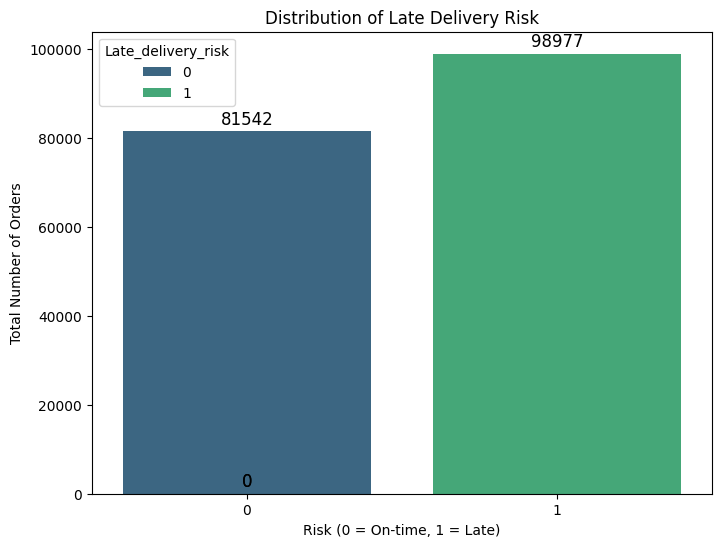

In [15]:
# 1. Check for 'Hidden' missing values
# Columns where a 0 is or could be impossible
cols_to_fix = df_supply.columns

print("Zero counts per column:")
for col in cols_to_fix:
    print(f"{col}: {(df_supply[col] == 0).sum()} zeros")

# 2. Visualize the Class Imbalance (Late_delivery_risk)
target = 'Late_delivery_risk'
plt.figure(figsize= (8,6))
ax = sns.countplot(x= target, data= df_supply, hue= target, palette= 'viridis')
plt.title('Distribution of Late Delivery Risk')
plt.xlabel('Risk (0 = On-time, 1 = Late)')
plt.ylabel('Total Number of Orders')

# Adding the exact count on top of bars
for x in ax.patches:
    ax.annotate(f'{int(x.get_height())}', (x.get_x() + x.get_width() / 2., x.get_height()), 
                ha= 'center', va= 'baseline', fontsize= 12, color= 'black', xytext= (0, 5),
                textcoords= 'offset points')
plt.show()

### 5.7.1 Conclusion on Hidden Values (those zeros) & Imbalance Target Chart
1. **The "Natural" Zeros (Safe to keep)**
These zeros make perfect sense in a business context:
    - Late_delivery_risk (81,542): These are just the orders that were on time.
    - Order_Item_Discount & Rate (10,028): These represent orders where no discount was applied.
2. **The Warning Zeros (Investigate or Drop)**
These are the ones that require your attention:
    - Product_Status (180,519): Every single row is 0. This column provides zero information (zero variance). We should drop this immediately as it's a "dead" column.
    - Days_for_shipping_real (5,080): A zero here implies the item was delivered the same day it was ordered.
        - Check: Cross the reference this with Shipping_Mode == 'Same Day'. If they match, the zeros are real.
    - Benefit_per_order / Order_Profit_Per_Order (1,177): These are orders where the company made exactly $0.00 profit. This is possible (break-even).
3. **The Suspicious Zeros**
    - Days_for_shipment_scheduled (9,737): This likely represents "Express" or "Same Day" shipping. Maybe the delivery was in a milk-run at a local area.

## 5.8 Categoric Variable Analysis

In [16]:
# 1. Convert the object column to a proper datetime format
df_supply['shipping_date_DateOrders'] = pd.to_datetime(df_supply['shipping_date_DateOrders'])

In [17]:
 # Only columns with object, str or categoric (nominal) data type
categorics = df_supply.select_dtypes(include= ['object','string']).columns.tolist()
print(f"Categorics variables: {categorics}")

Categorics variables: ['Type', 'Delivery_Status', 'Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Segment', 'Customer_State', 'Department_Name', 'Market', 'Order_City', 'Order_Country', 'Order_Region', 'Order_State', 'Order_Status', 'Product_Name', 'Shipping_Mode']


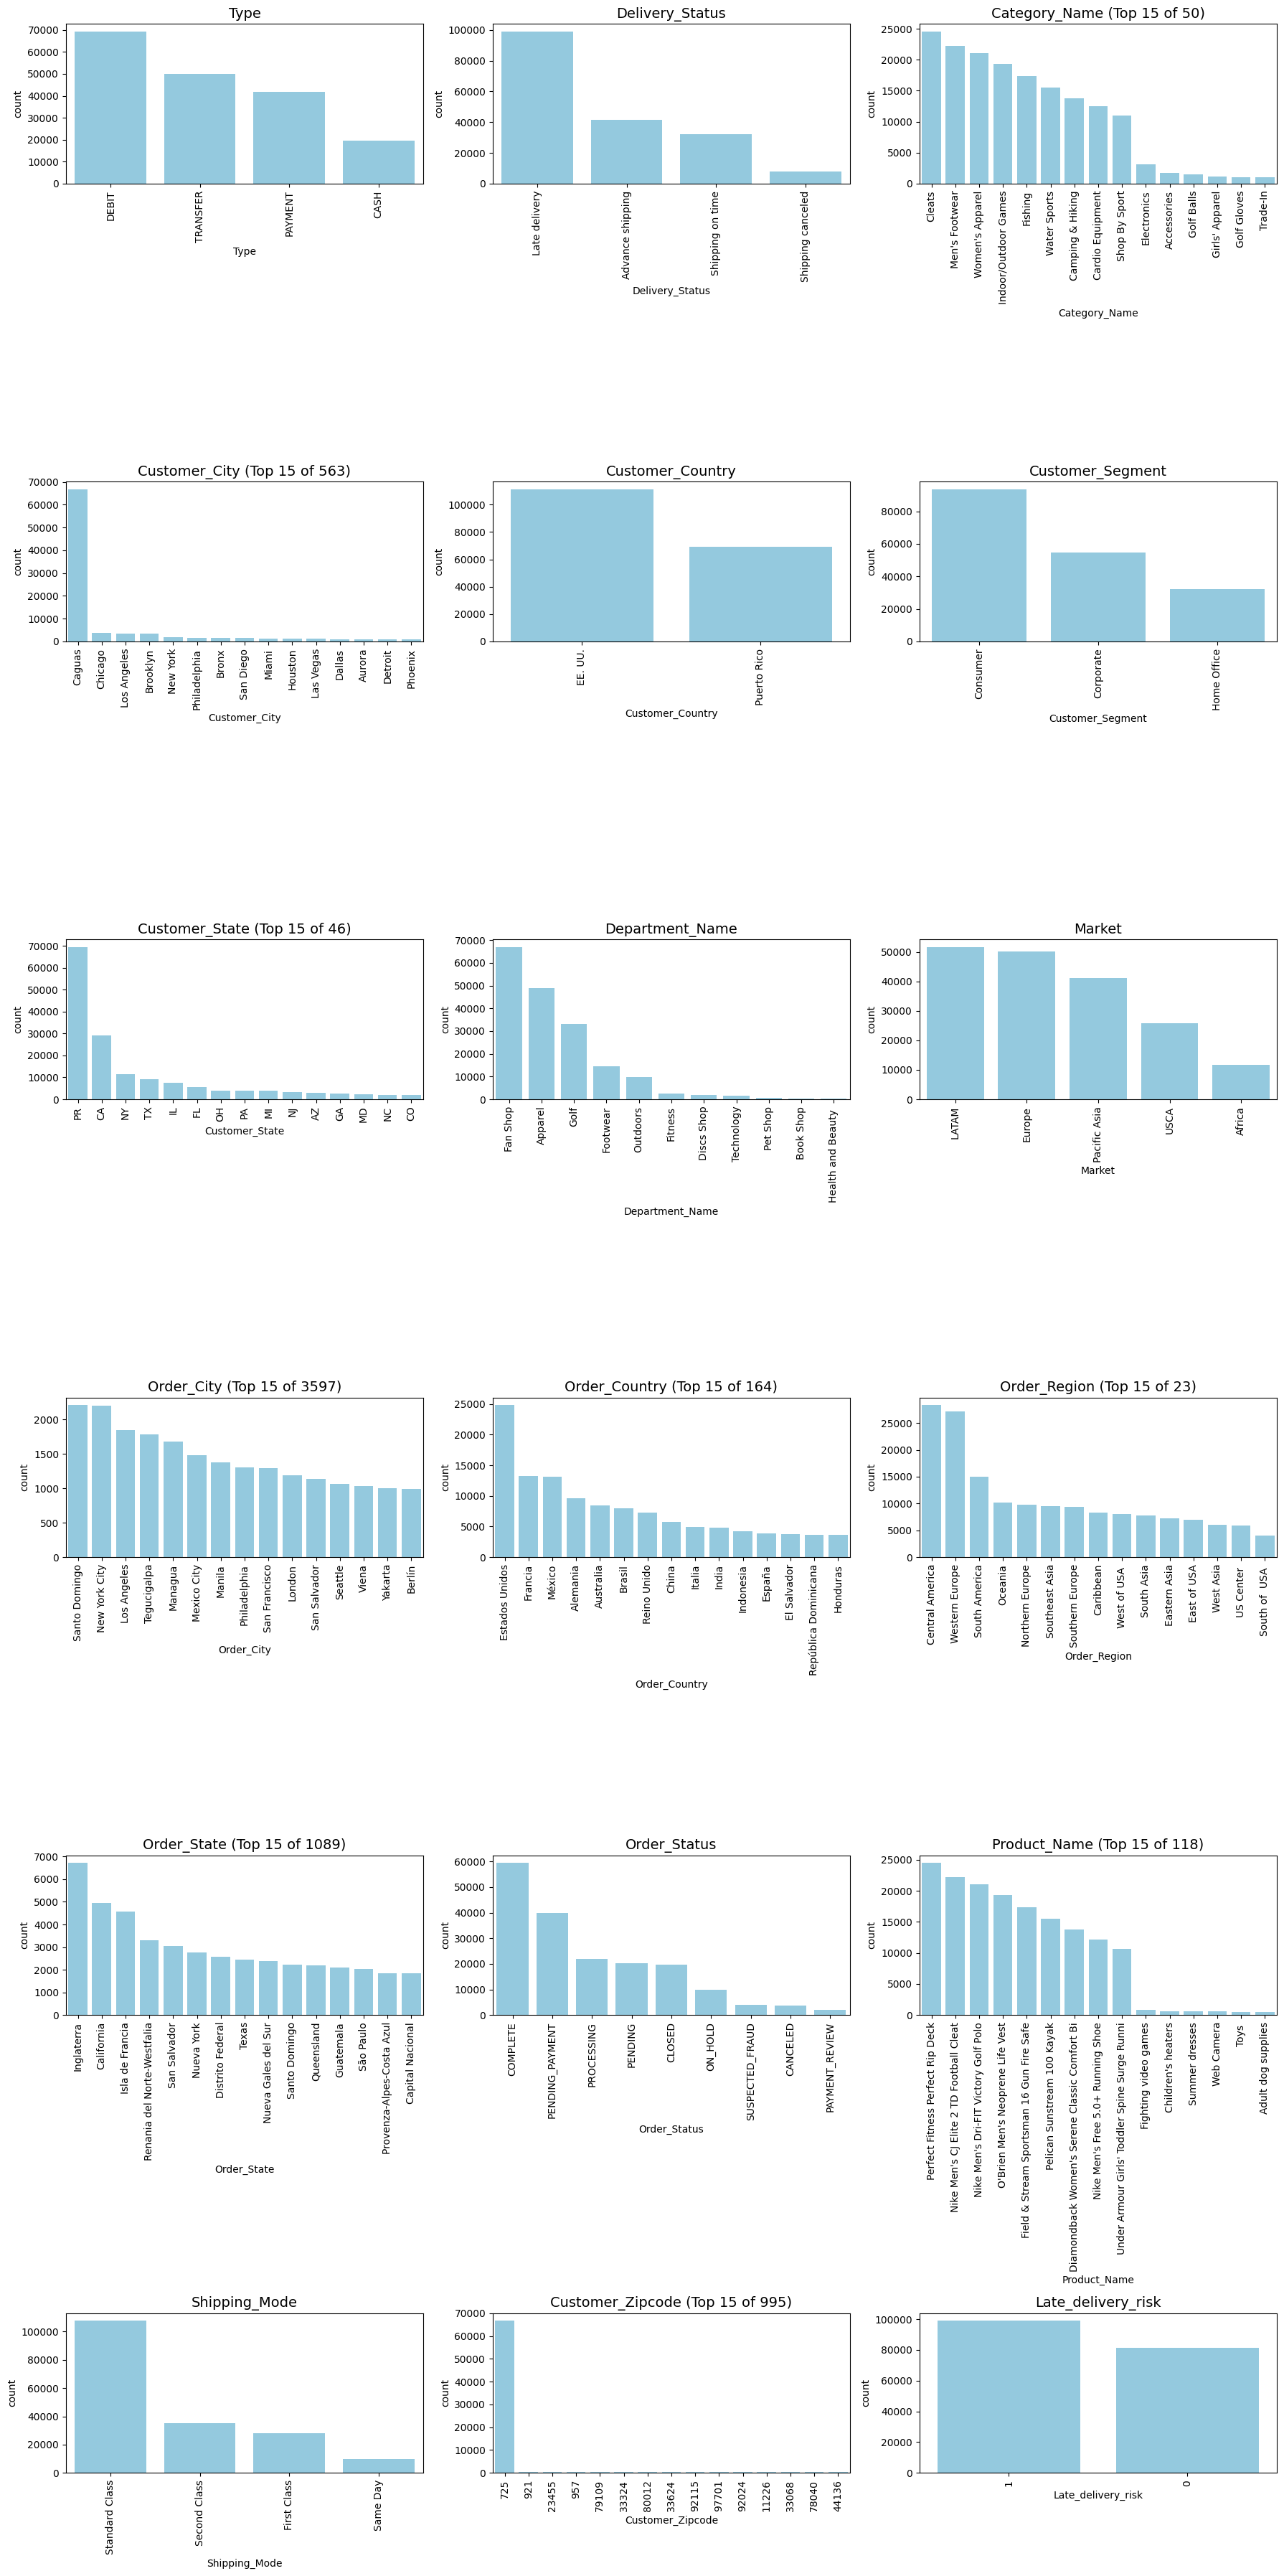

In [18]:
# CLEANING THE LIST: Remove duplicates to stop the repetition seen in the image
categorics = list(dict.fromkeys(categorics))
categoric_variable = ['Customer_Zipcode', 'Late_delivery_risk']
if not all(col in df_supply.columns for col in categoric_variable):
    missing_cols = [col for col in categoric_variable if col not in df_supply.columns]
    print(f"Missing columns: {missing_cols}")
else:
    categorics.extend(categoric_variable)

#1. Set up the grid
n_cols = 3
n_rows = math.ceil(len(categorics) / n_cols)
fig, axis = plt.subplots(n_rows, n_cols, figsize= (18, 6 * n_rows))
axis = axis.flatten()

# 2. Integrate plots with automatic logic
for i, col in enumerate(categorics):
    n_unique = df_supply[col].nunique()
    if n_unique > 15:
        top_15 = df_supply[col].value_counts().nlargest(15)
        plot_data = df_supply[df_supply[col].isin(top_15.index)].copy()
        
        # Convert BOTH the data and the order labels to clean strings
        if col == 'Customer_Zipcode':
            # Convert to float -> int -> str to remove the ".0"
            plot_data[col] = plot_data[col].astype(float).astype(int).astype(str)
            clean_order = [str(int(float(x))) for x in top_15.index]
        else:
            plot_data[col] = plot_data[col].astype(str)
            clean_order = [str(x) for x in top_15.index]
        
        # Use clean_order for BOTH 'order' and 'xticks'
        sns.countplot(ax=axis[i], data=plot_data, x=col, order=clean_order, color='skyblue')
        axis[i].set_title(f'{col} (Top 15 of {n_unique})', fontsize=14)
        axis[i].set_xticks(range(len(clean_order))) # Set positions
        axis[i].set_xticklabels(clean_order, rotation=90) # Set string labels
    else:
        # For small categories, let's force order for consistency
        sns.countplot(ax= axis[i], data= df_supply, x= col, order= df_supply[col].value_counts().index, color= 'skyblue')
        axis[i].set_title(f'{col}', fontsize= 14)
        axis[i].tick_params(axis='x', rotation= 90)
    
# Remove extra empty plot or grid
for j in range(len(categorics), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

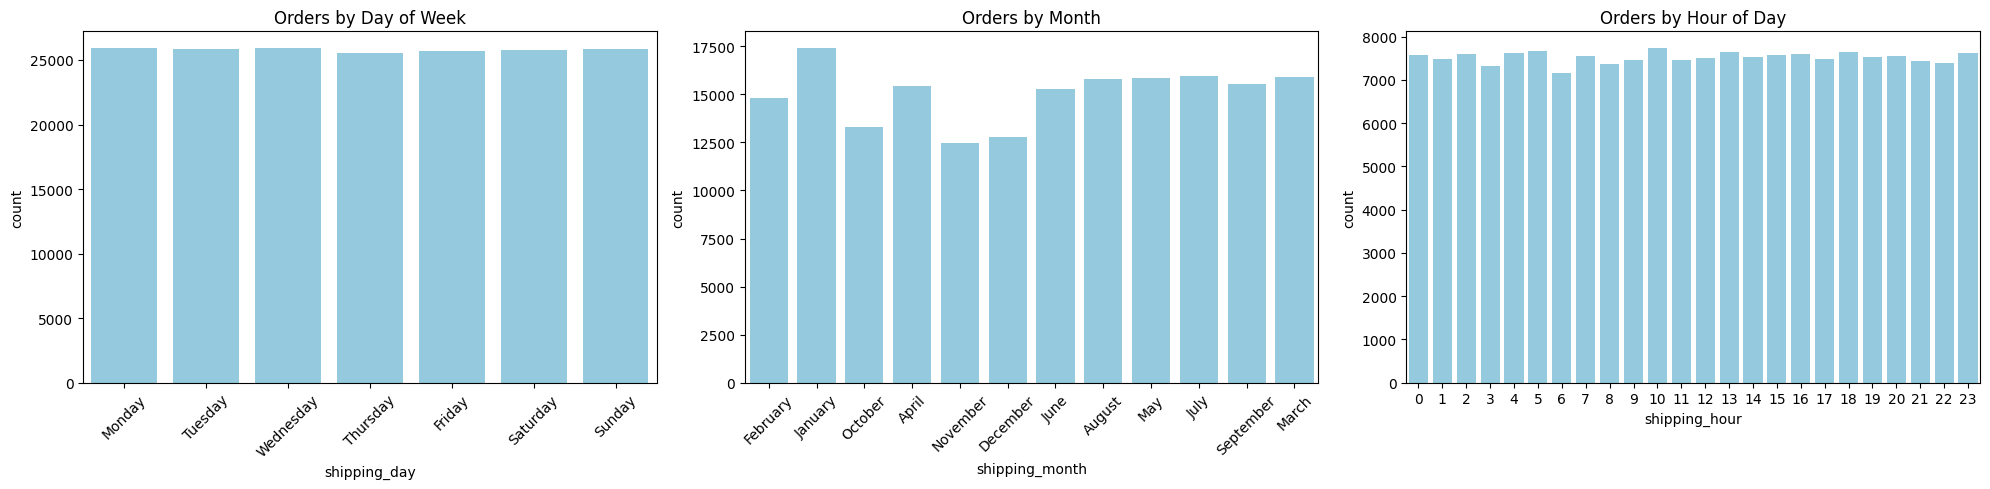

In [19]:
# 1. We have converted the object column to a proper datetime format above
# 2. Extract new features
df_supply['shipping_day'] = df_supply['shipping_date_DateOrders'].dt.day_name()
df_supply['shipping_month'] = df_supply['shipping_date_DateOrders'].dt.month_name()
df_supply['shipping_hour'] = df_supply['shipping_date_DateOrders'].dt.hour

# 3. Plot the new clean distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(ax= axes[0], data= df_supply, x= 'shipping_day', color= 'skyblue',
              order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].set_title('Orders by Day of Week')
axes[0].tick_params(axis= 'x', rotation= 45)

sns.countplot(ax= axes[1], data= df_supply, x= 'shipping_month', color= 'skyblue',)
axes[1].set_title('Orders by Month')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(ax= axes[2], data= df_supply, x= 'shipping_hour', color= 'skyblue',)
axes[2].set_title('Orders by Hour of Day')

plt.tight_layout()
plt.show()

### 5.8.1 Conclusions for Categorical Variable Charts

We want to share only key observations from the charts. - 

- **The Balanced Target:** The count plot for Late_delivery_risk shows a relatively balanced class distribution, which is a green light to proceed with standard classification algorithms without heavy resampling. 

- **The Shipping Dominance Effect:** Standard Class overwhelmingly dominates the shipping modes, suggesting it may be a strong predictor of delays and should be carefully evaluated in feature importance analysis. 

- **The Geographic Concentration:** Customer Country, State, City, and Zipcode show strong concentration in a few locations meaning these variables could carry high predictive power but will require proper encoding strategies to avoid overfitting. 

- **The Sales Concentration:** Departments, Categories, and specific Product Names are highly concentrated in a small subset of values

- **The Order Status Skewness:** The majority of orders are marked as Complete, making this variable less useful as a target but potentially informative as an operational feature.


## 5.9 Numeric Variable Analysis

In [20]:
# Select only columns with 'int or float' data type (numeric)
numerics = df_supply.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['Days_for_shipping_real', 'Days_for_shipment_scheduled', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk', 'Customer_Zipcode', 'Latitude', 'Longitude', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Product_Price', 'Order_Item_Profit_Ratio', 'Order_Item_Quantity', 'Sales', 'Order_Item_Total', 'Order_Profit_Per_Order', 'Product_Price', 'shipping_hour']


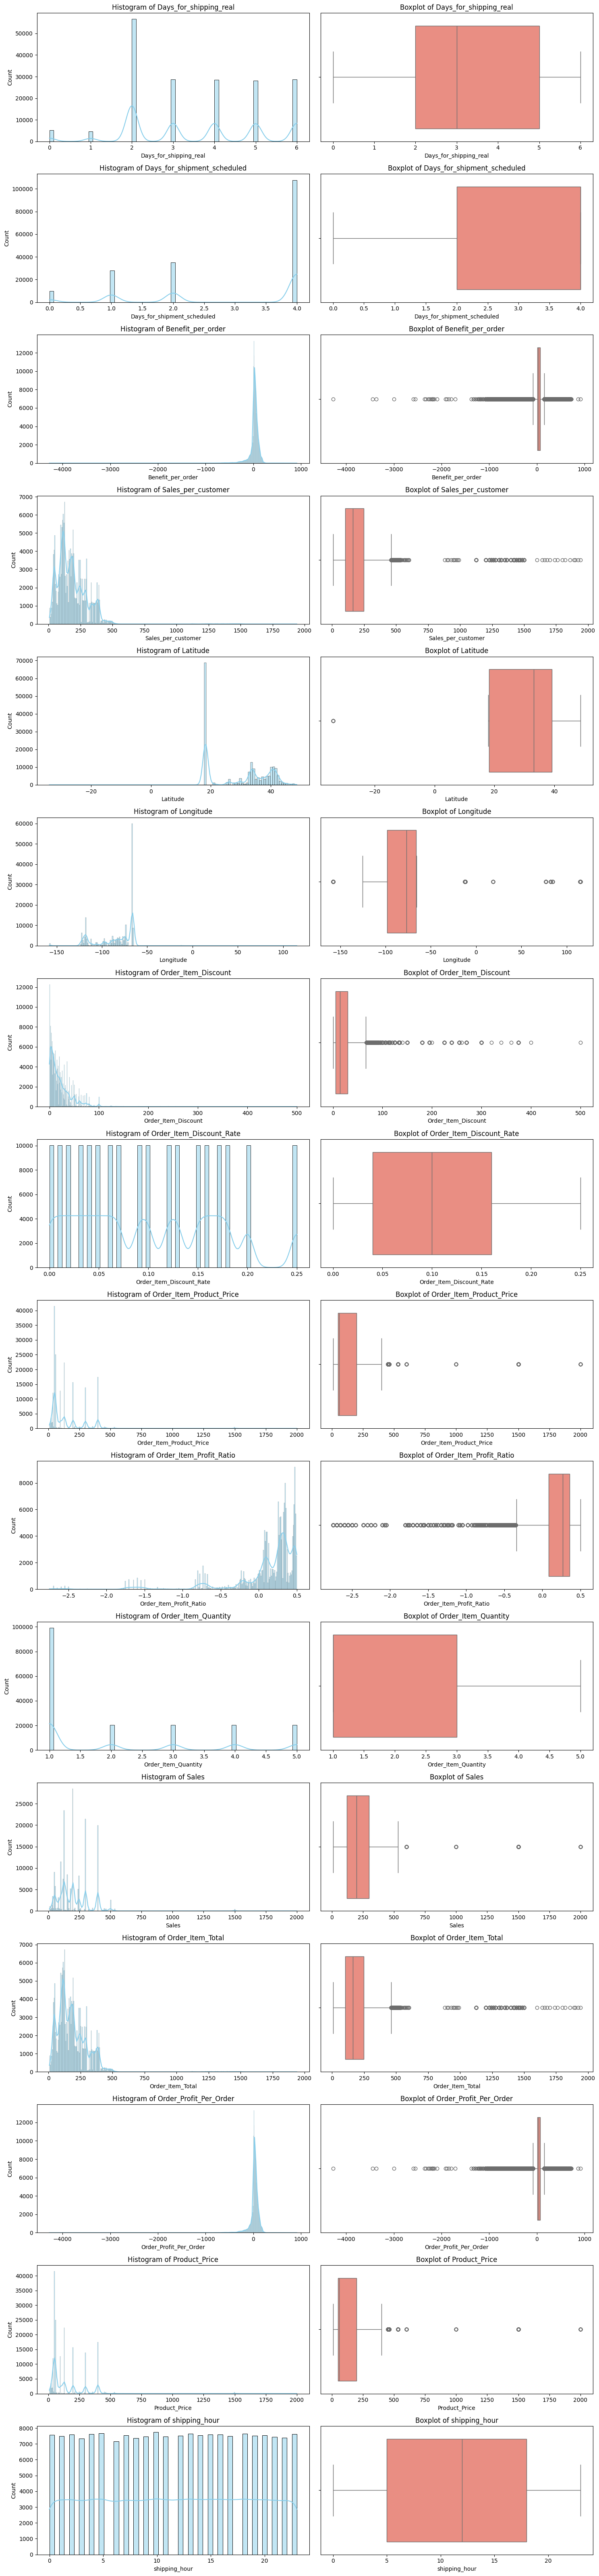

In [21]:
# Creating histplot and boxplot for the numeric variables
# Removing Customer_Zipcode and Late_delivery_risk from the list of numerics if it's there, since it's more of a categorical variable and can skew the visualizations.
numerics = [col for col in numerics if col not in ['Customer_Zipcode', 'Late_delivery_risk']]
if len(numerics) != 0:
    nrows = len(numerics)
    ncols = 2
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

    for i, col in enumerate(numerics):
        sns.histplot(df_supply[col], kde= True, ax= axes[i, 0], color= "skyblue")
        axes[i, 0].set_title(f'Histogram of {col}')
        sns.boxplot(x= df_supply[col], ax= axes[i, 1], color= "salmon")
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
else:
    print("There are no numercial variables or the list numerics might be empty")

### 5.8.1 Conclusions for Numerical Variable Charts
We want to share only key observations on the charts.
- **The "Gap" Distributions**: Days_for_shipping_real vs. Days_for_shipment_scheduled. Notice how the scheduled days have very specific "peaks" (discrete values), while the real days are more spread out.
- **The Profit Outliers**: The boxplot for Benefit_per_order and Order_Profit_Per_Order shows a very long "tail" of dots on the left side. They are extreme points that the model should help investigate.
- **The Skewed Revenue**: The Sales and Sales_per_customer histograms show a sharp peak on the left with a long tail to the right.
- **The Balanced Target**: The separate count plot for Late_delivery_risk is beautiful. It clearly shows the class balance, which is the "green light" to proceed with standard ML algorithms.

## 5.9 Categorical-Categorical Analysis (Multivariate Variables Analysis)

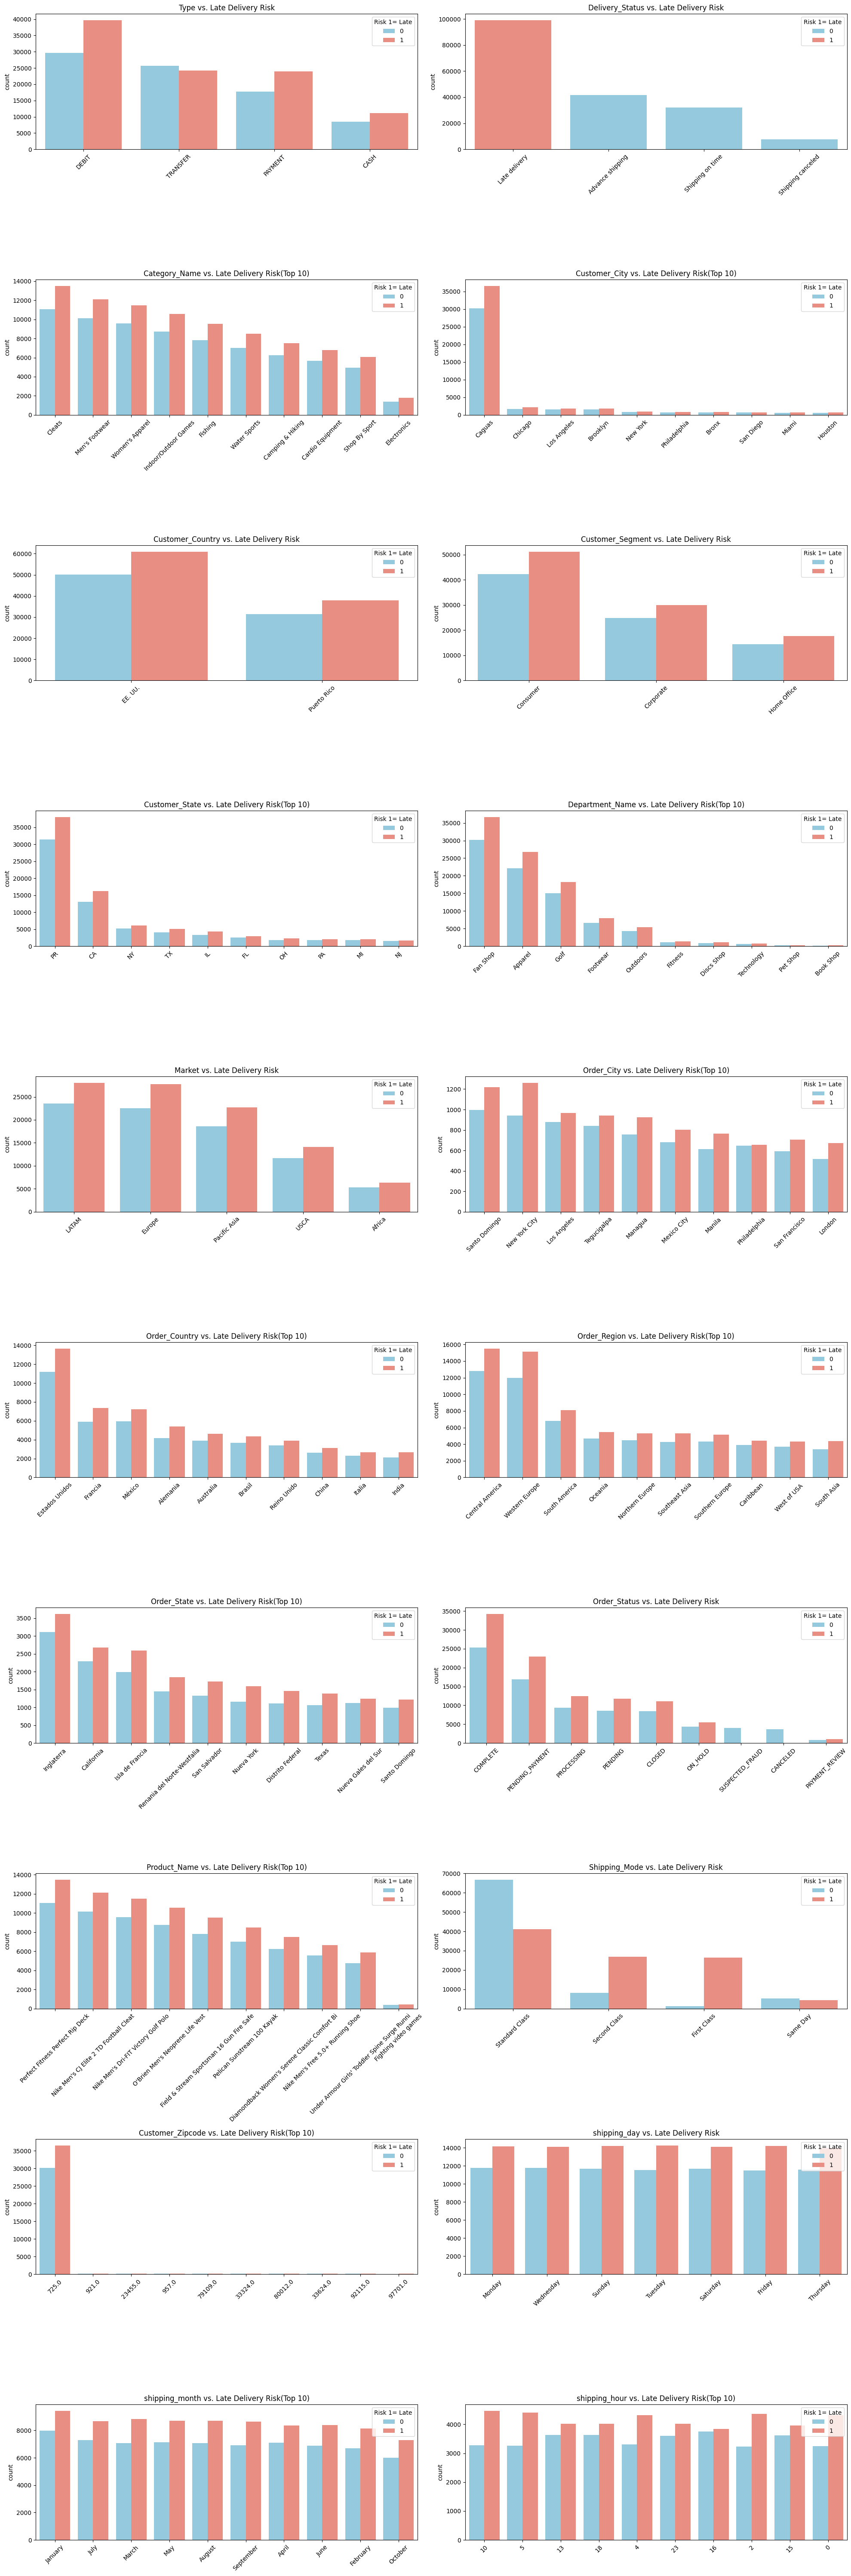

In [22]:
# List of categorical including the new features plus the Customer_Zipcode.
# Excluding the raw shipping_date sice we transformed it
if 'Late_delivery_risk' in categorics:
    categorics.remove('Late_delivery_risk')  # Removing late_delivery_risk if it's in the list of cols_to_plot
cols_to_plot = [c for c in categorics if c != 'shipping_date_DateOrders'] +  \
               ['shipping_day', 'shipping_month', 'shipping_hour']

# 1. Set up Grid
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)
fig, axis = plt.subplots(n_rows, n_cols, figsize= (20, 6 * n_rows))
axis = axis.flatten()

# 2. Loop through the columns and plot with the 'Late_delivery_risk' class as hue
for i, col in enumerate(cols_to_plot):
    # For high cardinality columns, only plot the top 10 to keep it readable
    if df_supply[col].nunique() > 10:
        top_10 = df_supply[col].value_counts().nlargest(10).index
        plot_data = df_supply[df_supply[col].isin(top_10)]
        title_suffix = "(Top 10)"
    else:
        plot_data = df_supply
        title_suffix = ""

    # Plotting with bars sorted by total count for better readability
    order = plot_data[col].value_counts().index
    sns.countplot(ax= axis[i], data= plot_data, x= col, hue= 'Late_delivery_risk', order= order, palette= ["skyblue","salmon"])
    axis[i].set_title(f'{col} vs. Late Delivery Risk{title_suffix}')
    axis[i].set_xlabel('')
    axis[i].legend(title= 'Risk 1= Late', loc= 'upper right')
    axis[i].tick_params(axis= 'x', rotation= 45)

# 3. Final clean up of the grid
for j in range(len(cols_to_plot), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()


### 5.9.1 Conclusion Cat - Cat Analysis
- **Type vs. Risk**: "DEBIT" and "TRANSFER" payments seem to have a higher volume of late deliveries compared to "CASH" or "PAYMENT"
- **Delivery Status vs. Risk**: We can see that the "Late Delivery" is 100% late and there is no blue bar. This is Delivery_Status is a duplicate of Late_delivery_risk.
- **Category_Name vs Risk**: High volume items like **Cleats**, **Men's Footwear**, and **Women's Apparel** dominate the late delivery counts.
- **Customer_Country vs Risk**: Puerto Rico shows a massive volume of late deliveries compared to the US. This is a critical geographical signal for your model.
- **Market vs Risk**: Europe and LATAM show the highest volume of late deliveries. This suggests that regional infrastructure or distance from warehouses in these areas is a major delay driver.
- **Order_Status vs Risk**: COMPLETE and PENDING statuses are heavily associated with risk. Conversely, CLOSED orders have a much healthier ratio, suggesting they are processed more successfully.
- **Shipping_Mode vs Risk**: This is the most significant "Predictor". First Class and Second Class have a disproportionately high green bar (Late) compared to blue (On Time).
- **Shipping_Day vs Risk**: Despite volumes being equal across the week, the risk of delay is consistently high every day. There is no "safe day" to ship in this dataset.
- **Shipping_Month vs Risk**: Risk peaks in January (post-holiday backlog) and May (seasonal peak). In contrast, October through December shows a significant decline in activity.


## 5.10 Numerical-Numerical Analysis (Multivariate Variables Analysis)

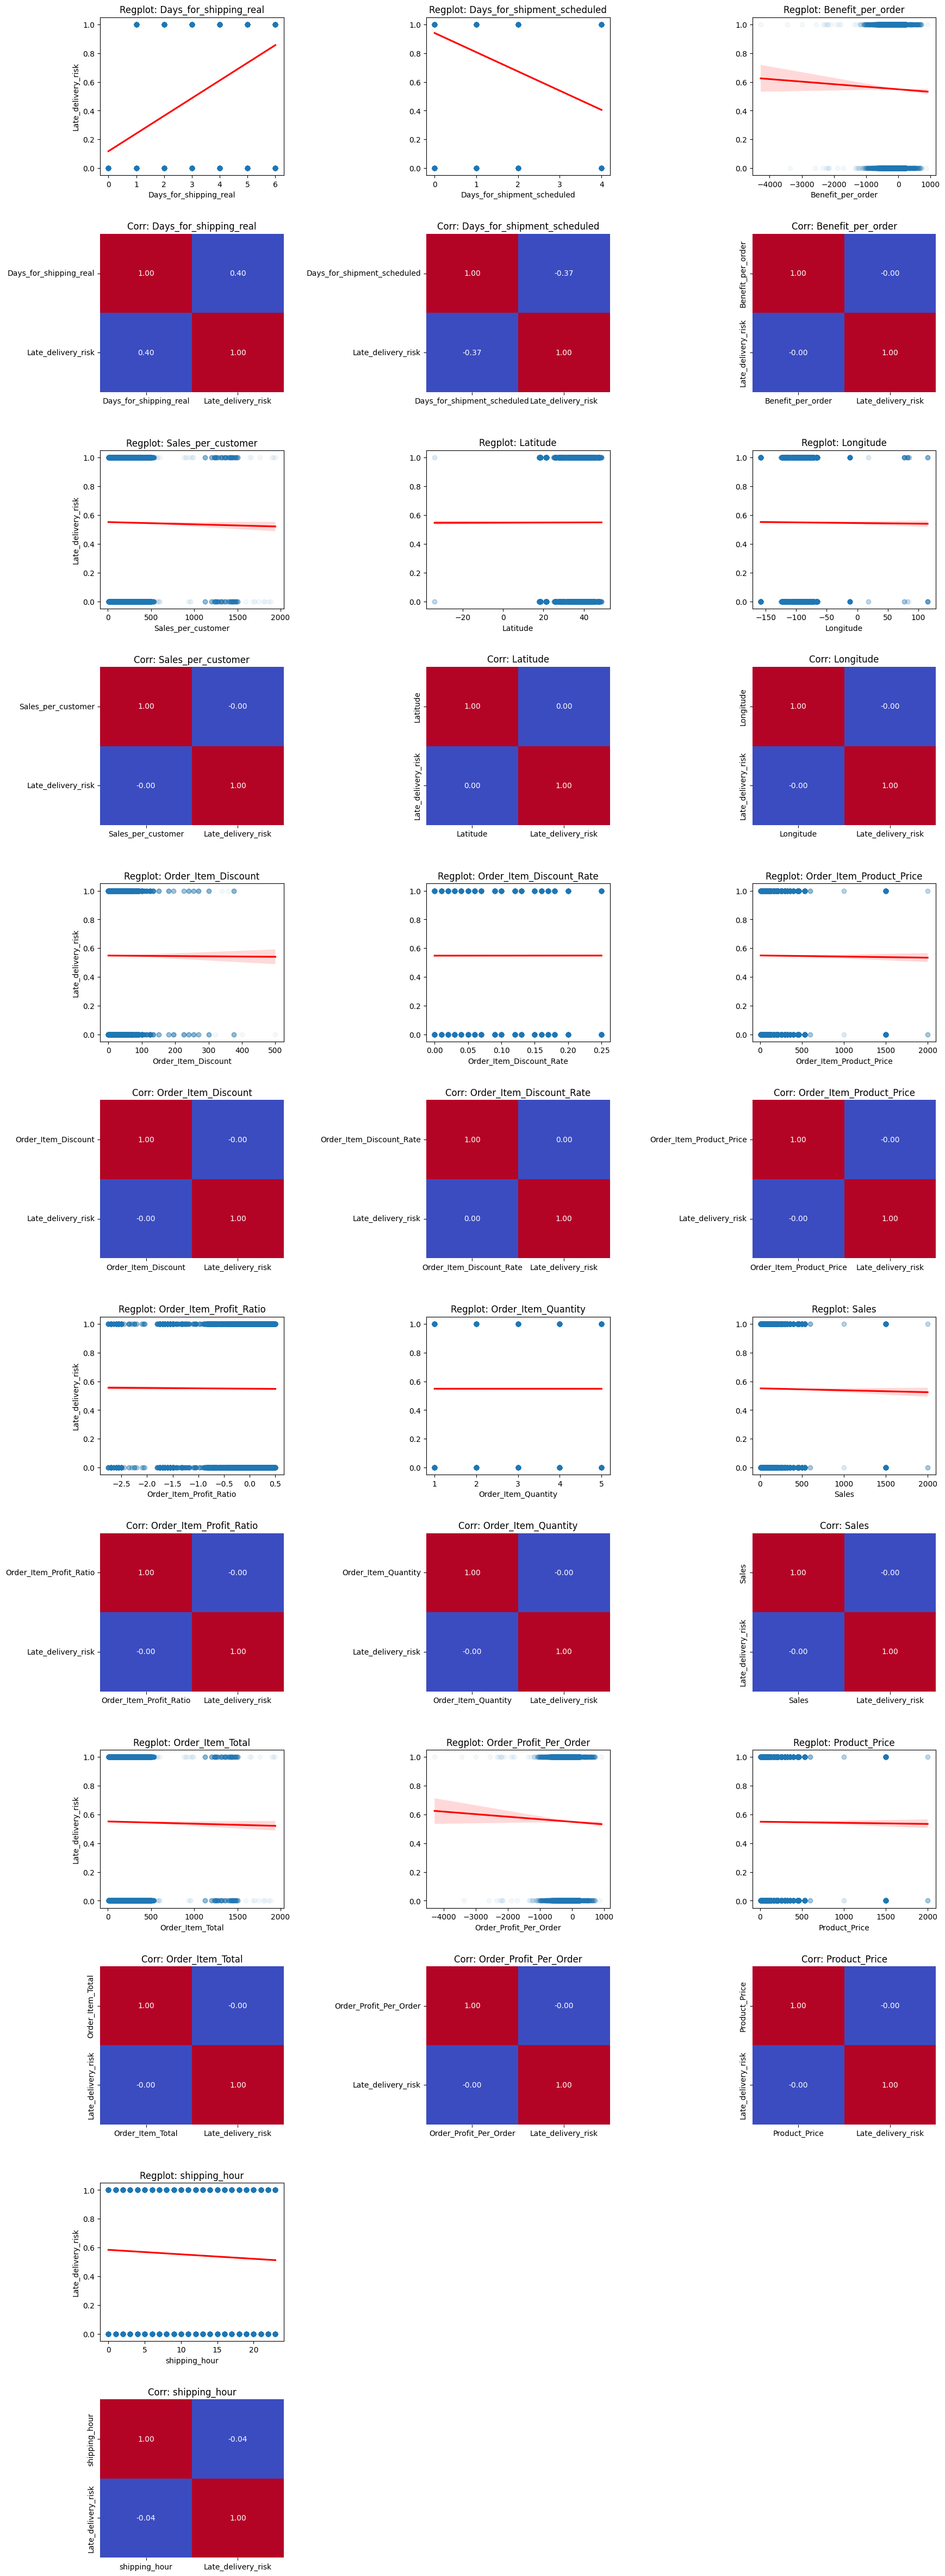

In [23]:
# 1. Excluding the target and Customer_Zipcode. The condition is to avoid ploting the target with itself.
numerics = [col for col in numerics if col not in ['Customer_Zipcode', 'Late_delivery_risk']]
target_num = 'Late_delivery_risk'

# 2. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df_supply, x= col, y= target_num, ax= axes[reg_row, col_idx], scatter_kws= {'alpha':0.05}, line_kws= {'color':'red'})
        axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        if col_idx > 0:
            axes[reg_row, col_idx].set(ylabel= None)
        # --- Plot 2: Heatmap ---
        sns.heatmap(df_supply[[col, target_num]].corr(), annot= True, fmt= ".2f", ax= axes[heat_row, col_idx], cmap= 'coolwarm', cbar= False)
        axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)


plt.tight_layout(pad= 3.0)
plt.show()

### 5.10.1 Num - Num Conclusion
* Let's see what those charts are telling us about thouse features or variables.
1. **The Logic Predictors: Shipping Days**
    - **Observation**: Days_for_shipping_real shows a nearly perfect positive correlation with the target. As actual shipping time increases, the risk of a late delivery becomes a certainty.
    - **Observation**: Days_for_shipment_scheduled shows a negative correlation. This indicates that orders with more generous planned delivery windows are significantly less likely to result in a late status.
2. **The Financial Indicators: Profit & Sales**
    - **Observation**: Benefit_per_order and Sales show very flat regression lines. This means that whether an order is highly profitable or a high-revenue sale, it doesn't necessarily change the probability of it being late.
    - **Observation**: The distribution of Benefit_per_order contains extreme negative outliers (losses over $4,000), suggesting that while profit doesn't predict lateness, lateness might be causing these financial cost impact.
3. **Geographical & Order Metrics**
    - **Observation**: Latitude, Longitude, and Order_Item_Quantity show near-zero correlation with Late_delivery_risk.
    - **Insight**: The physical location of the customer or the size of the order (quantity) are not the primary drivers of delays in this specific supply chain.

* **Decision for Modeling**:
- We must exclude Days_for_shipping_real from the training features to avoid Data Leakage, as this value is only known after the event has occurred.
- We should focus on Days_for_shipment_scheduled, Shipping_Mode, and Order_Region as our primary predictors.
- The presence of extreme outliers in Benefit_per_order justifies our previous decision to handle high-earners/outliers separately to prevent model distortion.

## 5.11 Correlation Analysis

In [24]:
# Factorize the categorical variables to prepare for the "Power Heatmap"
# The base list from before in cols_to_plot, excluding the new features since they are already numeric
# 1. Your existing safety check code
categoric_variable = ['Customer_Zipcode', 'Late_delivery_risk', 'shipping_day', 'shipping_month', 'shipping_hour']
if not all(col in df_supply.columns for col in categoric_variable):
    missing_cols = [col for col in categoric_variable if col not in df_supply.columns]
    print(f"Missing columns: {missing_cols}")
else:
    # Adding them to the master list for the heatmap
    categorics.extend(categoric_variable)

# 2. Ensure the directory exists to avoid FileNotFoundError
os.makedirs('../data/interim', exist_ok= True)

# 3. Factorize and build the mapping dictionary
mapping_dict = {}
for col in categorics:
    # pd.factorize returns (encoded_values, unique_labels)
    df_supply[col + '_num'], labels = pd.factorize(df_supply[col])
    
    # Store the labels as a list so we can map codes back to strings later
    mapping_dict[col] = list(labels)

# 4. Save the JSON file
with open('../data/interim/category_mappings.json', 'w') as f:
    json.dump(mapping_dict, f, indent= 4)

print("Factorization complete and JSON saved to data/interim/category_mappings.json")

Factorization complete and JSON saved to data/interim/category_mappings.json


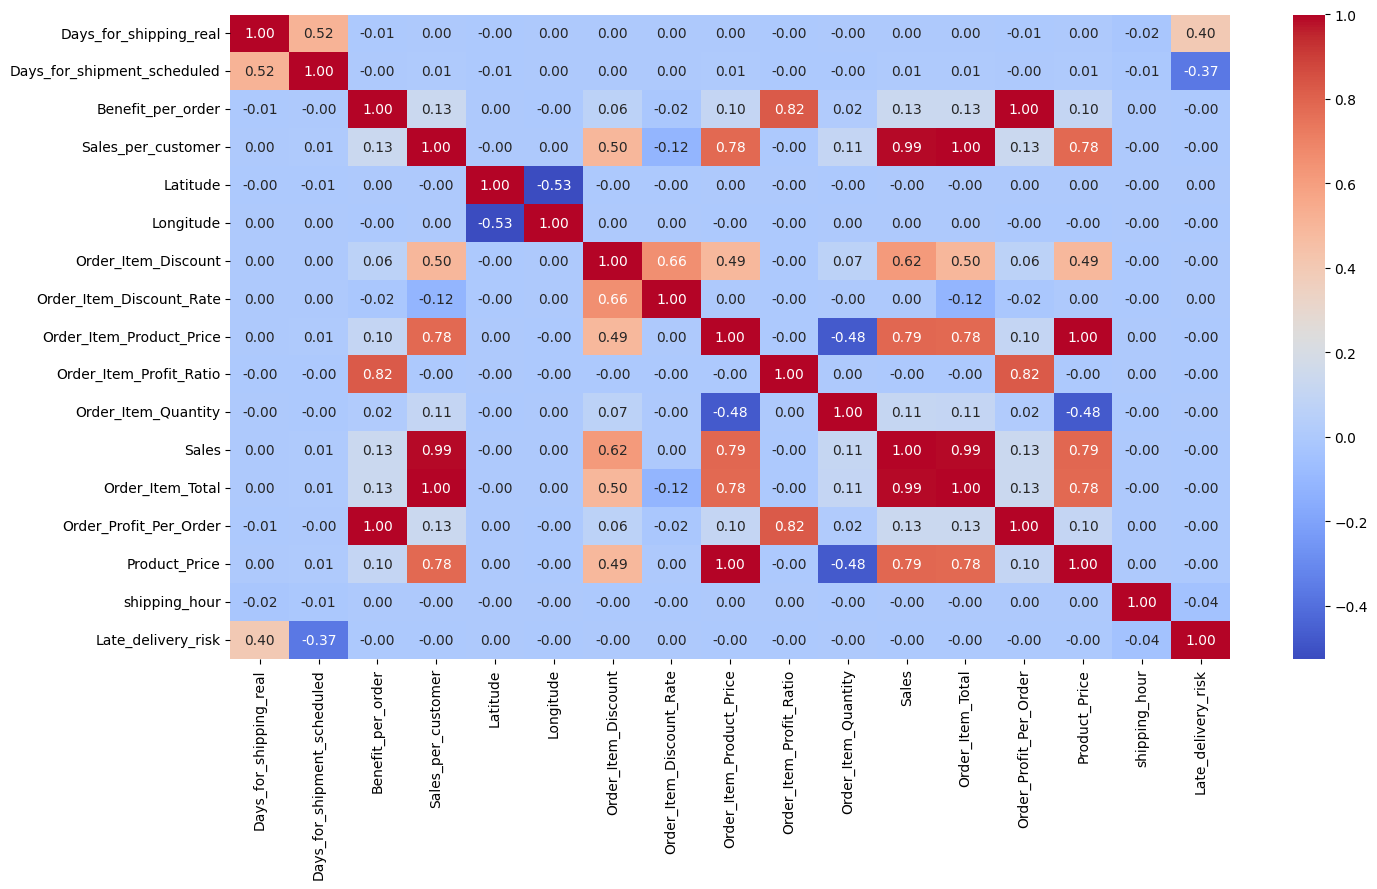

In [25]:
# Creating heatmap chart to analyze complete variables numerical correlation
cols_num = numerics + ['Late_delivery_risk'] # Ensure the target is included in the heatmap to see its correlation with the features
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_supply[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 5.11.1 Conclusion Correlation Heatmap

* Let’s review the information from our correlation chart and draw some conclusions:

    1. **Correlations of 0.99 – 1.00:**  
        - Sales <-> Order_Item_Total (~0.99) **--> Drop Order_Item_Total**
        - Sales <-> Sales_per_customer (~0.99) **--> Drop Sales_per_customer**
        - Product_Price <-> Order_Item_Product_Price (~1.00) **--> Drop Order_Item_Product_Price**
        - Benefit_per_order <-> Order_Profit_Per_Order (~1.00) **--> Drop Order_Profit_Per_Order**  
        - Order_Item_Total <-> Sales_per_customer  (~1.00) **--> Drop both**
        - Order_Item_Profit_Ratio <-> Benefit_per_order (0.82): **--> Drop Order_Item_Profit_Ratio**

    **Conclusion**: Redundant variables. In predictive models, this may cause multicollinearity.  
    **Recommendation**: Remove one variable from each pair when modeling.  

    2. **Strong Sales Relationship**:   

        - Sales <-> Order_Item_Product_Price (~0.79)  
        - Sales <-> Order_Item_Discount (~0.62)  
        - Sales <-> Order_Item_Total (~1.00)  

    **Conclusion**: Discounts show a positive correlation with sales; likely, when higher discounts are applied, sales volume increases.  
  
    3. **Shipping and Late Delivery Risk:**  

        - Days_for_shipping_real <-> Days_for_shipment_scheduled (~0.52): Moderately correlated. **-->Drop Days_for_shipping_real** LEAKAGE: We drop real because it contains the answer to whether the order is late.
        - Days_for_shipping_real <-> Late_delivery_risk (~0.40): More actual shipping days increase the risk of delay.  
        - Days_for_shipment_scheduled <-> Late_delivery_risk (-0.37): When the scheduled shipping time is longer, the risk decreases. This may indicate that planning with a larger time buffer reduces delays.  

In [26]:
# After factorization, we need to update the list of numeric variables to include the new '_num' columns and exclude the original categorical columns.
# But first let's use it for the new heatmap correlation between the new numeric variables and the target variable.
numerics_updated = [col for col in df_supply.select_dtypes(include= ['number']).columns.tolist() if col not in ['Late_delivery_risk', 'Customer_Zipcode', 'shipping_hour']]
print(f"Numeric variables after factorization: {numerics_updated}")
print(f"Total number of numeric variables: {len(numerics_updated)}")

Numeric variables after factorization: ['Days_for_shipping_real', 'Days_for_shipment_scheduled', 'Benefit_per_order', 'Sales_per_customer', 'Latitude', 'Longitude', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Product_Price', 'Order_Item_Profit_Ratio', 'Order_Item_Quantity', 'Sales', 'Order_Item_Total', 'Order_Profit_Per_Order', 'Product_Price', 'Type_num', 'Delivery_Status_num', 'Category_Name_num', 'Customer_City_num', 'Customer_Country_num', 'Customer_Segment_num', 'Customer_State_num', 'Department_Name_num', 'Market_num', 'Order_City_num', 'Order_Country_num', 'Order_Region_num', 'Order_State_num', 'Order_Status_num', 'Product_Name_num', 'Shipping_Mode_num', 'Customer_Zipcode_num', 'Late_delivery_risk_num', 'shipping_day_num', 'shipping_month_num', 'shipping_hour_num']
Total number of numeric variables: 36


## 5.12 Numerical- Categorical Analysis (complete)

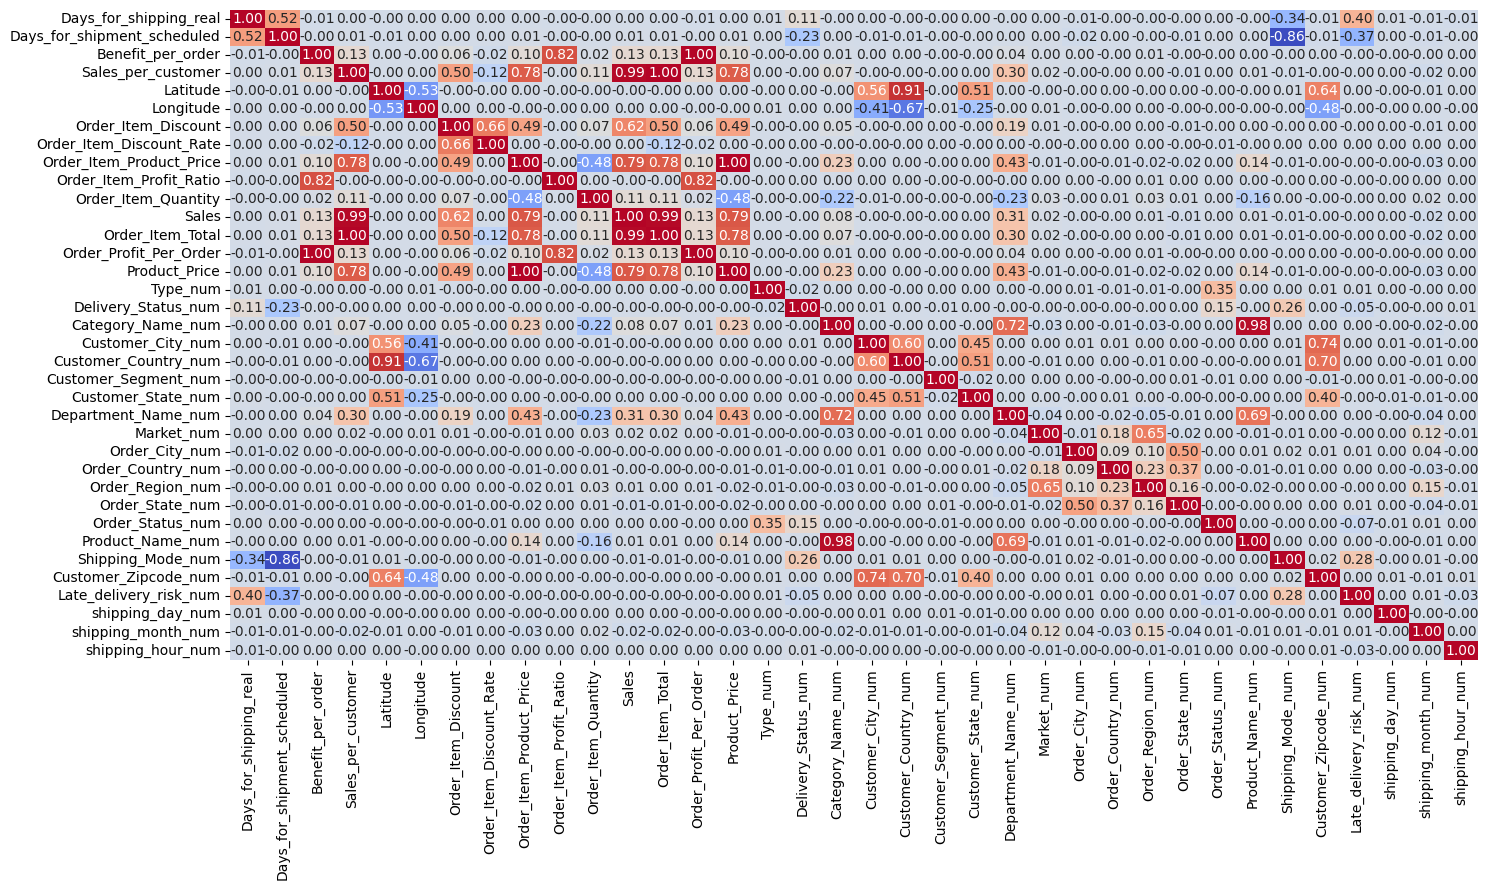

In [27]:
# Creating heatmap chart to analyze complete variables numerical-categorical correlation
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_supply[numerics_updated].corr(method= "pearson"), annot= True, fmt= ".2f", cbar= False, cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()


### 5.12.1 Conclusion Correlation Heatmap (Complete)
**The "Red Flag" Summary (High Multicollinearity)**
In the heatmap, the (1.00 correlation) indicate columns that provide identical information. Keeping both is redundant and can confuse the model.
1. **Sales Redundancy**: Sales, Sales_per_customer, Order_Item_Total, and Product_Price are almost perfectly correlated ($1.00$ or $0.99$).
2. **Profit Redundancy**: Benefit_per_order and Order_Profit_Per_Order are $1.00$ correlated.
3. **Shipping Logic**: Days_for_shipping_real and Days_for_shipment_scheduled are strongly correlated ($0.52$), and Late_delivery_risk is directly derived from the difference between these two ($0.40$ correlation).

* **COLUMNS TO DROP:**
- **cols_to_drop** = ['Days_for_shipping_real', 'Order_Profit_Per_Order', 'Sales_per_customer', 'Order_Item_Total', 'Latitude', 'Longitude', 'Product_Price', 'Product_Name_num', 'shipping_hour','Type', 'Delivery_Status', 'Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Segment', 'Customer_State', 'Department_Name', 'Market', 'Order_City', 'Order_Country', 'Order_Region', 'Order_State', 'Order_Status', 'Product_Name', 'Shipping_Mode', "Shipping_day_num", 'Customer_Zipcode', 'Late_delivery_risk']

In [28]:
target = 'Late_delivery_risk_num'
# Numeric_check.remove('Late_delivery_risk_num')  # Remove the target variable from the list of features for correlation analysis
if target in df_supply[numerics_updated].columns:
    correlation = df_supply[numerics_updated].corr()[target].sort_values(ascending= False)
    print("TOP CORRELATION WITH TARGET:")
    print(tabulate(pd.DataFrame(correlation), headers= "keys", tablefmt= "psql"))
else:
    print(f"Target variable '{target}' not found in the dataset.")

TOP CORRELATION WITH TARGET:
+-----------------------------+--------------------------+
|                             |   Late_delivery_risk_num |
|-----------------------------+--------------------------|
| Late_delivery_risk_num      |              1           |
| Days_for_shipping_real      |              0.401415    |
| Shipping_Mode_num           |              0.277919    |
| Order_State_num             |              0.0122501   |
| Order_City_num              |              0.0119621   |
| Type_num                    |              0.00901059  |
| shipping_month_num          |              0.00577299  |
| Customer_City_num           |              0.00458477  |
| Customer_Zipcode_num        |              0.00364046  |
| shipping_day_num            |              0.0028038   |
| Order_Country_num           |              0.0011385   |
| Department_Name_num         |              0.00105885  |
| Customer_Country_num        |              0.0010438   |
| Latitude                 

### 5.12.2 Quick Check Map Origin Location

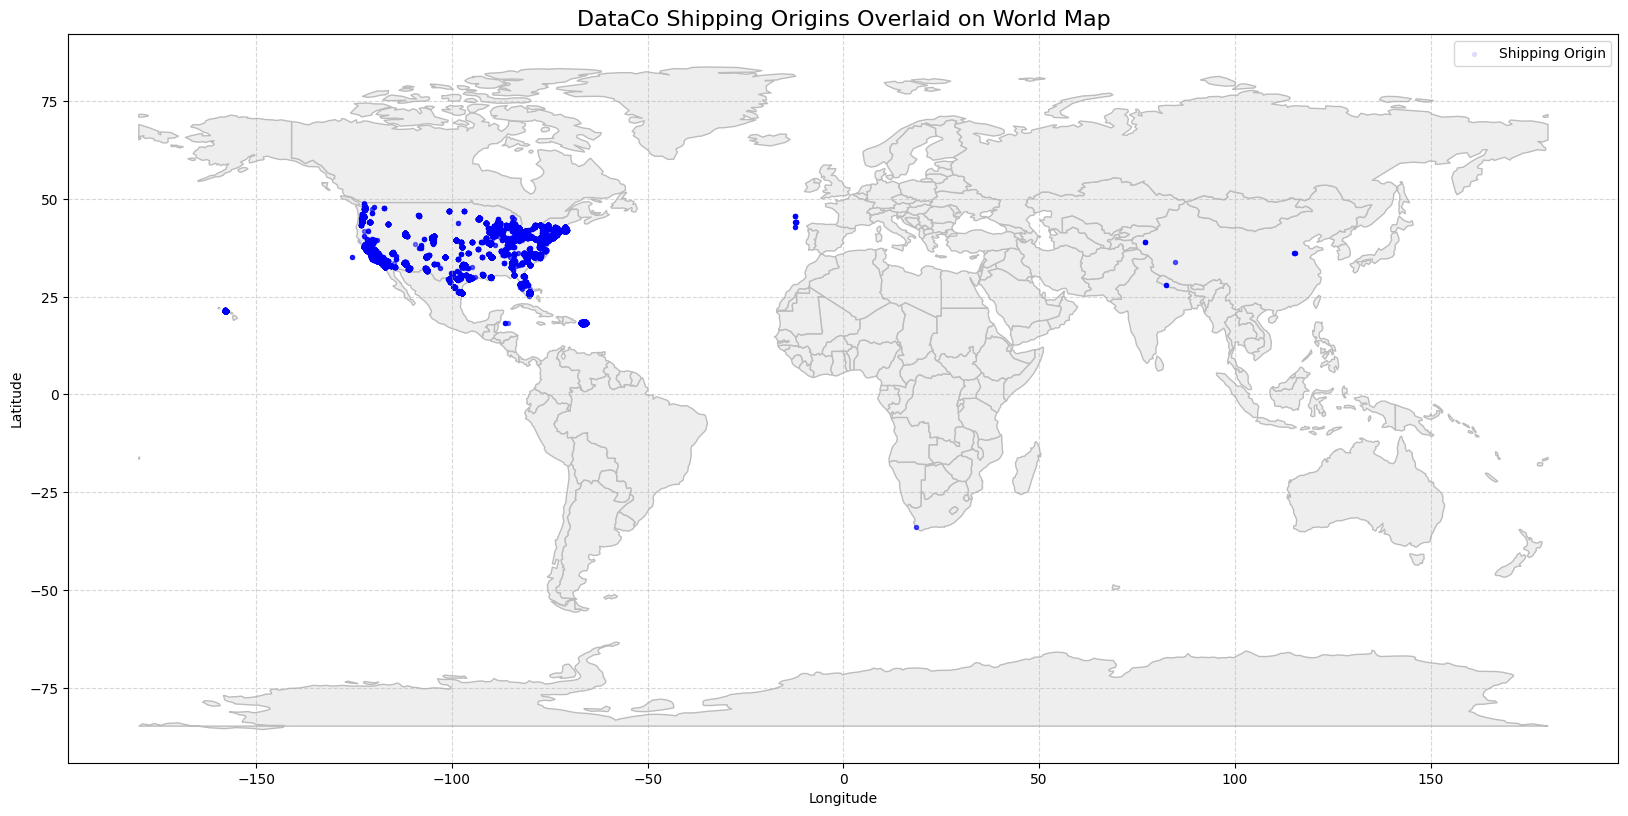

In [29]:
# Direct URL to the world map data
world_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
world = gpd.read_file(world_url)

fig, ax = plt.subplots(figsize=(20, 10))

# 1. Plot the background (using 'id' or 'name' for the world map)
world.plot(ax=ax, color='#eeeeee', edgecolor='#bcbcbc')

# 2. Overlay your DataCo coordinates
# Using your verified Latitude and Longitude columns
plt.scatter(df_supply['Longitude'], df_supply['Latitude'], 
            c='blue', s=8, alpha=0.1, label='Shipping Origin')

plt.title('DataCo Shipping Origins Overlaid on World Map', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

## 5.13 Final Dataset Cleaned

In [ ]:
cols_to_drop = ['Days_for_shipping_real', 'Order_Profit_Per_Order', 'Sales_per_customer', 'Order_Item_Total', 
                'Latitude', 'Longitude', 'Product_Price', 'Product_Name_num', 'shipping_date_DateOrders', 'Type', 'Delivery_Status', 
                'shipping_hour','Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Segment', 'Customer_Segment_num','Customer_State', 
                'shipping_day', 'Department_Name', 'Market', 'Order_City', 'Order_Country', 'Order_Region', 'Order_State', 
                'shipping_month', 'Order_Status', 'Product_Name', 'Shipping_Mode', 'Customer_Zipcode', 'Late_delivery_risk', "Shipping_day_num", "Customer_State_num", "Order_Region_num", "Order_State_num"]
df_final = df_supply.drop(columns= cols_to_drop, errors= 'ignore') # Using errors= 'ignore' to avoid issues if any column is missing
print(f"Final dataset shape after dropping columns: {df_final.shape}")
print("Remaining columns in the final dataset:")
print(df_final.columns.tolist())

Final dataset shape after dropping columns: (180519, 24)
Remaining columns in the final dataset:
['Days_for_shipment_scheduled', 'Benefit_per_order', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Product_Price', 'Order_Item_Profit_Ratio', 'Order_Item_Quantity', 'Sales', 'Type_num', 'Delivery_Status_num', 'Category_Name_num', 'Customer_City_num', 'Customer_Country_num', 'Department_Name_num', 'Market_num', 'Order_City_num', 'Order_Country_num', 'Order_Status_num', 'Shipping_Mode_num', 'Customer_Zipcode_num', 'Late_delivery_risk_num', 'shipping_day_num', 'shipping_month_num', 'shipping_hour_num']


In [33]:
# Use the fastparquet engine to bypass the ArrowKeyError
df_final.to_parquet('../data/processed/df_final_checkpoint.parquet', engine= 'fastparquet', index=False)
print("Checkpoint saved using fastparquet! Your progress is secure.")

Checkpoint saved using fastparquet! Your progress is secure.


In [1]:
# Creating pairplot to have a variables behaviour visibility
# Pick most interesting columns. We will include the target variable and some of the most correlated features with it, plus a few others for diversity.
target_cols = ['Days_for_shipment_scheduled', 'Shipping_Mode_num', 'Benefit_per_order', 'Sales', 'Late_delivery_risk_num']

# Sample 1000 rows so the computer doesn't explode
sns.pairplot(df_final[target_cols].sample(100), hue='Late_delivery_risk_num')
plt.show()
sns.pairplot(df_final)

NameError: name 'sns' is not defined